In [2]:
!pip install datasets transformers[ja,torch] matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 77.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.3 MB

In [3]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-wrime-sentiment"
sentiment_pipeline = pipeline(model=model_name, device="cuda:0")

In [10]:
from datasets import load_dataset

valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [11]:
from tqdm import tqdm

# ラベル名の情報を取得するためのClassLabelインスタンス
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を取得
    model_prediction = sentiment_pipeline(example["sentence"])[0]
    # 正解のラベルIDをラベル名に変換
    true_label = class_label.int2str(example["label"])

    # resultsに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )

6it [00:00, 14.27it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
1608it [00:27, 58.33it/s]


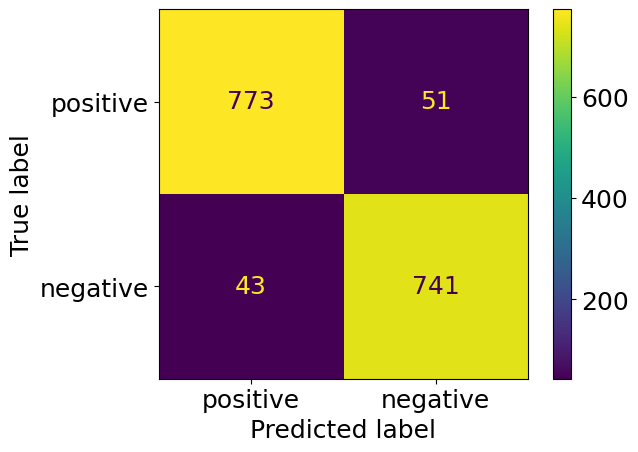

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

# 混同行列の作成
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)
# 混同行列を画像として表示
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=class_label.names
).plot()

In [13]:
# 予測が誤った事例を収集
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# モデルの予測確率が高い順にソート
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# 高い確率で予測しながら誤った事例の上位2件を表示
for top_result in sorted_failed_results[:5]:
    review_text = valid_dataset[top_result["example_id"]]["sentence"]
    print(f"レビュー文：{review_text}")
    print(f"予測：{top_result['pred_label']}")
    print(f"正解：{top_result['true_label']}")
    print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("----------------")

レビュー文：何のこれしき会社員だった頃の辛さに比べれば。まあ種類が違うけど。


予測：negative
正解：positive
予測確率: 0.9993
----------------
レビュー文：今年のプリキュアの決め台詞が、
 
「お大事に」

今年にマッチングし過ぎてて、プリキュアスタッフの先見の明がすご過ぎるし、何が言いたいかと言うと変身する棒を買わされました。
予測：positive
正解：negative
予測確率: 0.9993
----------------
レビュー文：ツイッター早朝部、いくわよ！！ あと諸事情により数人ブロックさせて頂きました…申し訳ない……
予測：negative
正解：positive
予測確率: 0.9992
----------------
レビュー文：酒はぬるめの 燗がいい 肴は炙った イカでいい←もっといいもの食えよ
予測：positive
正解：negative
予測確率: 0.9992
----------------
レビュー文：できれば今すぐお線香あげにいきたい
予測：positive
正解：negative
予測確率: 0.9992
----------------
